In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy
import plotly.graph_objects as go

from plotly.subplots import make_subplots

In [2]:
import sympy as sp
sp.init_printing()

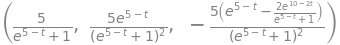

In [3]:
sp_t = sp.symbols('t', real=True) #sp_theta = sp.Function('theta', real=True)(sp_t)

#sp_f_ref =sp.sin(sp_t)**2 #sp.sin(sp_t)
#sp_f_ref,sp.diff(sp_f_ref,sp_t),sp.diff(sp_f_ref,sp_t,2)
sp_f_ref = 1/(1 + sp.exp(-sp_t + 5)) * 5
#sp.plot(sp_f_ref,(sp_t,-10,10))
sp_f_ref,sp.diff(sp_f_ref,sp_t),sp.diff(sp_f_ref,sp_t,2)

In [4]:
print( sp_f_ref) 
print( sp.diff(sp_f_ref,sp_t))
print( sp.diff(sp_f_ref,sp_t,2))  

5/(exp(5 - t) + 1)
5*exp(5 - t)/(exp(5 - t) + 1)**2
-5*(exp(5 - t) - 2*exp(10 - 2*t)/(exp(5 - t) + 1))/(exp(5 - t) + 1)**2


# Simulacion reducida

In [5]:
class Pendulo:

    def __init__(self, x0=[np.pi/4,0],nombre='Pendulo sin ruido'):

        self.theta = np.zeros(k_steps)      # ángulo
        self.theta_dot = np.zeros(k_steps)  # velocidad angular
        self.z_theta = np.zeros(k_steps)      # ángulo
        self.z_theta_dot = np.zeros(k_steps)  # velocidad angular
        self.u = np.zeros(k_steps)          # control

        self.theta[0] = x0[0]    # 45 grados
        self.theta_dot[0] = x0[1] # velocidad inicial cero   
        self.z_theta[0] = x0[0]    # 45 grados
        self.z_theta_dot[0] = x0[1] # velocidad inicial cero   

        self.nombre = nombre

    # Esta funcion trabaja con pasos k, y no con todo el tiempo t
    def system (self,x,u,ruido=0):
        theta = x[0]
        theta_dot = x[1]

        dtheta = theta_dot + ruido[0]
        dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2) + ruido[1]

        theta_k1 = theta + T*dtheta
        theta_dot_k1 = theta_dot + T*dtheta_dot

        return np.array([theta_k1, theta_dot_k1])

    # Esta funcion trabaja con pasos k 
    def control_retroalimentacion(self,estado, k):
        #theta_ref = np.sin(t)
        #dtheta_ref = np.cos(t)  
        #ddtheta_ref = -np.sin(t)
        # Estas referencias es con t = k  
        t = k 
        theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
        dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
        ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 
        
        theta,dtheta = estado  #+ np.random.normal(0,0.002,(estado.shape) )
        k1,k2 = 10,20 #2,1
        
        e = theta - theta_ref  # Error
        de = dtheta - dtheta_ref  # Derivada del error

        u = m*l**2*( ddtheta_ref - k1*(de) -k2*(e) + (b/(m*l**2))*dtheta + (g/l)*np.sin(theta) )  # Control
        return u

    def update(self,k,ruido_medicion=np.array([0,0]),ruido_proceso=[0,0]):
        x = np.array([self.theta[k], self.theta_dot[k]])
        z = x + ruido_medicion
        self.u[k+1] = self.control_retroalimentacion(z, t[k])
        self.theta[k+1], self.theta_dot[k+1] = self.system(x, self.u[k+1], ruido_proceso )
        self.z_theta[k+1], self.z_theta_dot[k+1] = z
        
        return z
    
    def update_RHONN(self,k,u,ruido_medicion=np.array([0,0]),ruido_proceso=[0,0]):
        x = np.array([self.theta[k], self.theta_dot[k]])
        z = x + ruido_medicion
        self.u[k+1] = u #self.control_retroalimentacion(z, t[k])
        self.theta[k+1], self.theta_dot[k+1] = self.system(x, self.u[k+1], ruido_proceso )
        self.z_theta[k+1], self.z_theta_dot[k+1] = z
        
        return z

    def datos(self):
        return self.theta,self.theta_dot

    def datos_z(self):
        return self.z_theta,self.z_theta_dot

In [6]:
# Parámetros del sistema
m = 1.0     # masa (kg)
l = 1.0     # longitud (m)
g = 9.81    # gravedad (m/s²)
b = 0.1     # fricción (N⋅m⋅s/rad)

# Parámetros de simulación
T = 0.01    # período de muestreo (s)
t_final = 10  # tiempo final de simulación (s)
k_steps = int(t_final/T)  # número de pasos
n_edos = 2  # número de ecuaciones diferenciales

# Vectores para almacenar resultados
t = np.arange(0, t_final, T)  # vector de tiempo

# Calcular referencia
theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 

np.random.seed(158)
#ruido_medicion = cauchy.rvs(loc=0, scale=0.01, size=(k_steps,n_edos)) #np.random.normal(0,0.1,(k_steps,n_edos) )
#ruido_proceso = cauchy.rvs(loc=0, scale=0.05, size=(k_steps,n_edos)) #np.random.normal(0,0.15,(k_steps,n_edos) )

ruido_medicion = np.random.normal(0,0.02,(k_steps,n_edos) )
ruido_proceso = np.random.normal(0,0.3,(k_steps,n_edos) )
# Simulación usando método de Euler

penduloSinRuido = Pendulo(nombre='Pendulo sin ruido')
penduloConRuidoMedicion = Pendulo(nombre='Pendulo con ruido de medicion')
penduloConRuidoProceso = Pendulo(nombre='Pendulo con ruido de proceso')
penduloConRuidoMedicionProceso = Pendulo(nombre='Pendulo con ruido de medicion y proceso')

for k in range(k_steps-1):
    # Entrada de control (en este caso 0 para oscilación libre)
    #u = 0#control_retroalimentacion([theta[k], theta_dot[k]], t[k])

    # Sistema sin ruido
    #x = np.array([theta[k], theta_dot[k]])
    penduloSinRuido.update(k)
    

    # Sistema con ruido de medicion 
    penduloConRuidoMedicion.update(k,ruido_medicion[k,:])

    # Sistema con ruido de proceso
    penduloConRuidoProceso.update(k,ruido_proceso=ruido_proceso[k,:])

    # Sistema con ruido de medicion y proceso
    penduloConRuidoMedicionProceso.update(k,ruido_medicion[k,:],ruido_proceso[k,:])

theta,theta_dot = penduloSinRuido.datos_z()
theta_ruido_medicion,theta_ruido_medicion_dot = penduloConRuidoMedicion.datos_z()
theta_ruido_proceso,theta_ruido_proceso_dot = penduloConRuidoProceso.datos_z()
theta_ruido_medicion_proceso,theta_ruido_medicion_proceso_dot = penduloConRuidoMedicionProceso.datos_z()

In [7]:

# Crear los subplots
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Ángulo del Péndulo', 'Velocidad Angular'),
                   vertical_spacing=0.15)

graph = lambda y,color,name: go.Scatter(x=t, y=y, name=name, line=dict(color=color))

# Gráfica del ángulo (primera subfigura)
fig.add_trace( graph(theta,'blue','θ'), row=1, col=1)
fig.add_trace( graph(theta_ruido_medicion,'red','θ+ruido medición'), row=1, col=1)
fig.add_trace( graph(theta_ruido_proceso,'cyan','θ+ruido proceso'), row=1, col=1)
fig.add_trace( graph(theta_ruido_medicion_proceso,'magenta','θ+ruido medición+proceso'), row=1, col=1)
fig.add_trace( graph(theta_ref,'green','θ_ref'), row=1, col=1)


# Gráfica de la velocidad angular (segunda subfigura)
fig.add_trace( graph(theta_dot,'blue','ω'), row=2, col=1)
fig.add_trace( graph(theta_ruido_medicion_dot,'red','ω+ruido medición'), row=2, col=1)
fig.add_trace( graph(theta_ruido_proceso_dot,'cyan','ω+ruido proceso'), row=2, col=1)
fig.add_trace( graph(theta_ruido_medicion_proceso_dot,'magenta','ω+ruido medición+proceso'), row=2, col=1)


# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   ),
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Ángulo θ (rad)', row=1, col=1)
fig.update_yaxes(title_text='Velocidad Angular θ̇ (rad/s)', row=2, col=1)


# Mostrar la figura
fig.show()

In [8]:
penduloSinRuido 
penduloConRuidoMedicion 
penduloConRuidoProceso 
penduloConRuidoMedicionProceso 

In [9]:
class FiltroParticulas:
    def __init__(self, pendulo, n_particulas=100, std_medicion=0.1, std_proceso=0.1):
        """
        Inicializa el filtro de partículas para el péndulo
        
        Args:
            pendulo: Instancia de la clase Pendulo
            n_particulas: Número de partículas a usar
            std_medicion: Desviación estándar del ruido de medición
            std_proceso: Desviación estándar del ruido de proceso
        """
        self.pendulo = pendulo
        self.n_particulas = n_particulas
        self.std_medicion = std_medicion
        self.std_proceso = std_proceso
        
        # Inicializar partículas alrededor del estado inicial
        self.particulas_theta = np.random.normal(pendulo.theta[0], 0.1, n_particulas)
        self.particulas_theta_dot = np.random.normal(pendulo.theta_dot[0], 0.1, n_particulas)
        
        # Pesos de las partículas
        self.pesos = np.ones(n_particulas) / n_particulas
        
        # Arrays para almacenar estimaciones
        self.theta_estimado = np.zeros_like(pendulo.theta)
        self.theta_dot_estimado = np.zeros_like(pendulo.theta_dot)
        
        # Almacenar el estado inicial
        self.theta_estimado[0] = np.average(self.particulas_theta, weights=self.pesos)
        self.theta_dot_estimado[0] = np.average(self.particulas_theta_dot, weights=self.pesos)

    def predecir(self, k):
        """
        Propaga las partículas a través del modelo del sistema
        """
        for i in range(self.n_particulas):
            # Estado actual de la partícula
            estado = np.array([self.particulas_theta[i], self.particulas_theta_dot[i]])
            
            # Calcular control para esta partícula
            u = self.pendulo.control_retroalimentacion(estado, t[k])
            
            # Generar ruido de proceso para esta partícula
            ruido_proceso = np.random.normal(0, self.std_proceso, 2)
            
            # Propagar la partícula
            estado_siguiente = self.pendulo.system(estado, u, ruido_proceso)
            
            # Actualizar partículas
            self.particulas_theta[i] = estado_siguiente[0]
            self.particulas_theta_dot[i] = estado_siguiente[1]

    def actualizar(self, medicion):
        """
        Actualiza los pesos de las partículas basado en la medición
        """
        for i in range(self.n_particulas):
            # Calcular probabilidad de la medición dado el estado de la partícula
            prob_theta = np.exp(-0.5 * ((self.particulas_theta[i] - medicion[0]) / self.std_medicion)**2)
            prob_theta_dot = np.exp(-0.5 * ((self.particulas_theta_dot[i] - medicion[1]) / self.std_medicion)**2)
            
            # Actualizar peso
            self.pesos[i] *= prob_theta * prob_theta_dot
        
        # Normalizar pesos
        self.pesos += 1e-300  # Evitar división por cero
        self.pesos /= np.sum(self.pesos)

    def remuestrear(self):
        """
        Remuestrea las partículas basado en sus pesos
        """
        # Calcular número efectivo de partículas
        neff = 1.0 / np.sum(self.pesos**2)
        
        # Remuestrear si el número efectivo es menor que la mitad del total
        if neff < self.n_particulas/2:
            # Remuestreo sistemático
            posiciones = (np.random.random() + np.arange(self.n_particulas)) / self.n_particulas
            indices = np.zeros(self.n_particulas, 'i')
            cumsum = np.cumsum(self.pesos)
            
            i, j = 0, 0
            while i < self.n_particulas:
                if posiciones[i] < cumsum[j]:
                    indices[i] = j
                    i += 1
                else:
                    j += 1
            
            # Actualizar partículas y pesos
            self.particulas_theta = self.particulas_theta[indices]
            self.particulas_theta_dot = self.particulas_theta_dot[indices]
            self.pesos = np.ones(self.n_particulas) / self.n_particulas

    def estimar_estado(self, k):
        """
        Calcula la estimación del estado basado en las partículas
        """
        self.theta_estimado[k] = np.average(self.particulas_theta, weights=self.pesos)
        self.theta_dot_estimado[k] = np.average(self.particulas_theta_dot, weights=self.pesos)
        
        return np.array([self.theta_estimado[k], self.theta_dot_estimado[k]])

    def actualizar_filtro(self, k, medicion):
        """
        Ejecuta un paso completo del filtro de partículas
        """
        self.predecir(k)
        self.actualizar(medicion)
        self.remuestrear()
        return self.estimar_estado(k)

    def obtener_estimaciones(self):
        """
        Retorna las estimaciones del filtro
        """
        return self.theta_estimado, self.theta_dot_estimado

    def obtener_particulas(self):
        """
        Retorna el estado actual de las partículas y sus pesos
        """
        return self.particulas_theta, self.particulas_theta_dot, self.pesos

In [10]:
# Ejemplo de uso
def simular_con_filtro_particulas(pendulo, n_particulas=100):
    """
    Simula el péndulo con el filtro de partículas
    """
    # Crear filtro de partículas
    pf = FiltroParticulas(pendulo, n_particulas=n_particulas)
    
    # Simulación
    for k in range(k_steps-1):
        # Actualizar péndulo
        medicion = pendulo.update(k, ruido_medicion[k], ruido_proceso[k])
        
        # Actualizar filtro de partículas
        estado_estimado = pf.actualizar_filtro(k, medicion)
    
    return pf

# Crear instancia del péndulo
pendulo = Pendulo(nombre='Pendulo con ruido')

# Simular con filtro de partículas
pf = simular_con_filtro_particulas(pendulo, n_particulas=100)

In [11]:

# Crear los subplots
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Ángulo del Péndulo', 'Velocidad Angular'),
                   vertical_spacing=0.15)

graph = lambda y,color,name: go.Scatter(x=t, y=y, name=name, line=dict(color=color))

# Gráfica del ángulo (primera subfigura)
fig.add_trace( graph(theta,'blue','θ'), row=1, col=1)
fig.add_trace( graph(theta_ruido_medicion,'red','θ+ruido medición'), row=1, col=1)
fig.add_trace( graph(theta_ruido_proceso,'cyan','θ+ruido proceso'), row=1, col=1)
fig.add_trace( graph(theta_ruido_medicion_proceso,'magenta','θ+ruido medición+proceso'), row=1, col=1)
fig.add_trace( graph(theta_ref,'green','θ_ref'), row=1, col=1)
fig.add_trace( graph(pendulo.z_theta,'orange','θ Mediciones'), row=1, col=1)
fig.add_trace( graph(pf.theta_estimado,'pink','θ Estimado PF'), row=1, col=1)


# Gráfica de la velocidad angular (segunda subfigura)
fig.add_trace( graph(theta_dot,'blue','ω'), row=2, col=1)
fig.add_trace( graph(theta_ruido_medicion_dot,'red','ω+ruido medición'), row=2, col=1)
fig.add_trace( graph(theta_ruido_proceso_dot,'cyan','ω+ruido proceso'), row=2, col=1)
fig.add_trace( graph(theta_ruido_medicion_proceso_dot,'magenta','ω+ruido medición+proceso'), row=2, col=1)
fig.add_trace( graph(pf.theta_dot_estimado,'pink','ω+rEstimado PF'), row=2, col=1)


# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   ),
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Ángulo θ (rad)', row=1, col=1)
fig.update_yaxes(title_text='Velocidad Angular θ̇ (rad/s)', row=2, col=1)


# Mostrar la figura
fig.show()

In [12]:
class FiltroParticulasRHONN:
    def __init__(self, pendulo, n_particulas=100,n_weights=4, std_medicion=0.1, std_proceso=0.1):
        """
        Inicializa el filtro de partículas para el péndulo
        
        Args:
            pendulo: Instancia de la clase Pendulo
            n_particulas: Número de partículas a usar
            std_medicion: Desviación estándar del ruido de medición
            std_proceso: Desviación estándar del ruido de proceso
        """

        self.S = lambda x: 1/(1 + np.exp(-x)) # TODO: pasarla a la clase
        self.wf = .001
        self.pendulo = pendulo
        self.n_particulas = n_particulas
        self.std_medicion = std_medicion
        self.std_proceso = std_proceso
        self.n_particulas_weights = np.random.normal(0,1,(n_particulas,n_weights))
        
        
        # Inicializar partículas alrededor del estado inicial
        self.particulas_theta = np.random.normal(pendulo.theta[0], 0.1, n_particulas)
        self.particulas_theta_dot = np.random.normal(pendulo.theta_dot[0], 0.1, n_particulas)
        
        self.particulas_theta_RHONNs = np.random.normal(pendulo.theta[0], 0.1, n_particulas)
        self.particulas_theta_RHONNs_dot = np.random.normal(pendulo.theta_dot[0], 0.1, n_particulas)
        
        # Pesos de las partículas
        self.pesos = np.ones(n_particulas) / n_particulas
        
        # Arrays para almacenar estimaciones
        self.theta_estimado = np.zeros_like(pendulo.theta)
        self.theta_dot_estimado = np.zeros_like(pendulo.theta_dot)
        self.RHONN_weights = np.zeros(( len(pendulo.theta_dot),n_weights))

        # Almacenar el estado inicial
        self.theta_estimado[0] = np.average(self.particulas_theta, weights=self.pesos)
        self.theta_dot_estimado[0] = np.average(self.particulas_theta_dot, weights=self.pesos)



    def predecir(self, k):
        """
        Propaga las partículas a través del modelo del sistema
        """
        
        for i in range(self.n_particulas):
            # Estado actual de la partícula
            estado = np.array([self.particulas_theta[i], self.particulas_theta_dot[i]])
            
            # Calcular control para esta partícula
            u = self.pendulo.control_retroalimentacion(estado, t[k])
            
            # Generar ruido de proceso para esta partícula
            ruido_proceso = np.random.normal(0, self.std_proceso, 2)
            
            # Propagar la partícula
            estado_siguiente = self.pendulo.system(estado, u, ruido_proceso)
            
            
            w_1 = int(self.n_particulas_weights[i,0])
            w_2 = int(self.n_particulas_weights[i,1])
            w_3 = int(self.n_particulas_weights[i,2])
            w_4 = int(self.n_particulas_weights[i,3])
            
            w0 = np.array([ [w_1],[w_2]] )
            w1 = np.array([ [w_3],[w_4]] )
            x0,x1 = estado_siguiente
            H1 = np.array( [ [self.S (x0)], [self.S (x1)] ] )
            H2 = np.array( [ [self.S (x0)], [self.S (x1)] ] )
            
            X0 = w0.T@H1
            X1 = w1.T@H2 + self.wf*u

            # Actualizar partículas
            self.particulas_theta[i] = x0#estado_siguiente[0]
            self.particulas_theta_dot[i] = x1#estado_siguiente[1]
            self.particulas_theta_RHONNs[i] = X0#estado_siguiente[0]
            self.particulas_theta_RHONNs_dot[i] = X1#estado_siguiente[1]

    def actualizar(self, medicion):
        """
        Actualiza los pesos de las partículas basado en la medición
        """
        for i in range(self.n_particulas):
            # Calcular probabilidad de la medición dado el estado de la partícula
            prob_theta = np.exp(-0.5 * ((self.particulas_theta[i] - medicion[0]) / self.std_medicion)**2)
            prob_theta_dot = np.exp(-0.5 * ((self.particulas_theta_dot[i] - medicion[1]) / self.std_medicion)**2)
            
            prob_theta_RHONNs = np.exp(-0.5 * ((self.particulas_theta_RHONNs[i] - medicion[0]) / self.std_medicion)**2)
            prob_theta_RHONNs_dot = np.exp(-0.5 * ((self.particulas_theta_RHONNs_dot[i] - medicion[1]) / self.std_medicion)**2)
            
            # Actualizar peso
            self.pesos[i] *= prob_theta * prob_theta_dot * prob_theta_RHONNs * prob_theta_RHONNs_dot
            #self.pesos[i] *=  prob_theta_RHONNs * prob_theta_RHONNs_dot
        
        # Normalizar pesos
        self.pesos += 1e-300  # Evitar división por cero
        self.pesos /= np.sum(self.pesos)

    def remuestrear(self):
        """
        Remuestrea las partículas basado en sus pesos
        """
        # Calcular número efectivo de partículas
        neff = 1.0 / np.sum(self.pesos**2)
        
        # Remuestrear si el número efectivo es menor que la mitad del total
        if neff < self.n_particulas/2:
            # Remuestreo sistemático
            posiciones = (np.random.random() + np.arange(self.n_particulas)) / self.n_particulas
            indices = np.zeros(self.n_particulas, 'i')
            cumsum = np.cumsum(self.pesos)
            
            i, j = 0, 0
            while i < self.n_particulas:
                if posiciones[i] < cumsum[j]:
                    indices[i] = j
                    i += 1
                else:
                    j += 1
            
            # Actualizar partículas y pesos
            self.particulas_theta = self.particulas_theta[indices]
            self.particulas_theta_dot = self.particulas_theta_dot[indices]
            self.n_particulas_weights = self.n_particulas_weights[indices]
            self.pesos = np.ones(self.n_particulas) / self.n_particulas

    def estimar_estado(self, k):
        """
        Calcula la estimación del estado basado en las partículas
        """
        self.theta_estimado[k] = np.average(self.particulas_theta, weights=self.pesos)
        self.theta_dot_estimado[k] = np.average(self.particulas_theta_dot, weights=self.pesos)
        self.RHONN_weights[k] = np.average(self.n_particulas_weights, weights=self.pesos, axis=0)
        
        return np.array([self.theta_estimado[k], self.theta_dot_estimado[k]]),self.RHONN_weights[k]
        

    def actualizar_filtro(self, k, medicion):
        """
        Ejecuta un paso completo del filtro de partículas
        """
        self.predecir(k)
        self.actualizar(medicion)
        self.remuestrear()
        return self.estimar_estado(k)

    def obtener_estimaciones(self):
        """
        Retorna las estimaciones del filtro
        """
        return self.theta_estimado, self.theta_dot_estimado

    def obtener_particulas(self):
        """
        Retorna el estado actual de las partículas y sus pesos
        """
        return self.particulas_theta, self.particulas_theta_dot, self.pesos

In [13]:
S = lambda x: 1 / (1 + np.exp(-x))
X0 = np.zeros(len(pendulo.theta )) 
X1 = np.zeros(len(pendulo.theta_dot)) 
X0[0] = pendulo.theta[0]
X1[0] = pendulo.theta_dot[0]

# Ejemplo de uso
def simular_con_filtro_particulas(pendulo, n_particulas=100):
    """
    Simula el péndulo con el filtro de partículas
    """
    # Crear filtro de partículas
    pf_RHONN = FiltroParticulasRHONN(pendulo, n_particulas=n_particulas)


    # Simulación
    for k in range(k_steps-1):
        # Actualizar péndulo
        u = pendulo.control_retroalimentacion(np.array([X0[k],X1[k]]), t[k])
        medicion = pendulo.update_RHONN(k,u, ruido_medicion[k], ruido_proceso[k])
        #medicion = pendulo.update(k, ruido_medicion[k], ruido_proceso[k])
        
        
        # Actualizar filtro de partículas
        estados,n_particulas_weights = pf_RHONN.actualizar_filtro(k, medicion)
        x0,x1 = estados
        w_1 = n_particulas_weights[0]
        w_2 = n_particulas_weights[1]
        w_3 = n_particulas_weights[2]
        w_4 = n_particulas_weights[3]
        
        w0 = np.array([ [w_1],[w_2]] )
        w1 = np.array([ [w_3],[w_4]] )
        H1 = np.array( [ [S(x0)], [S(x1)] ] )
        H2 = np.array( [ [S(x0)], [S(x1)] ] )
       
        X0[k+1] = (w0.T@H1).item()
        X1[k+1] = (w1.T@H2 + pf_RHONN.wf*pendulo.u[k]).item() # TODO: controlador esta diseñado del sistema no de la RHONN
        
    
    return pf_RHONN

# Crear instancia del péndulo
pendulo = Pendulo(nombre='Pendulo con ruido')

# Simular con filtro de partículas
pf_RHONN = simular_con_filtro_particulas(pendulo, n_particulas=100)

/tmp/ipykernel_565905/4158793565.py:79: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_565905/4158793565.py:80: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [14]:

# Crear los subplots
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Ángulo del Péndulo', 'Velocidad Angular'),
                   vertical_spacing=0.15)

graph = lambda y,color,name: go.Scatter(x=t, y=y, name=name, line=dict(color=color))

# Gráfica del ángulo (primera subfigura)
fig.add_trace( graph(theta,'blue','θ'), row=1, col=1)
fig.add_trace( graph(theta_ruido_medicion,'red','θ+ruido medición'), row=1, col=1)
fig.add_trace( graph(theta_ruido_proceso,'cyan','θ+ruido proceso'), row=1, col=1)
fig.add_trace( graph(theta_ruido_medicion_proceso,'magenta','θ+ruido medición+proceso'), row=1, col=1)
fig.add_trace( graph(theta_ref,'green','θ_ref'), row=1, col=1)
fig.add_trace( graph(pendulo.z_theta,'orange','θ Mediciones'), row=1, col=1)
fig.add_trace( graph(pf.theta_estimado,'pink','θ Estimado PF'), row=1, col=1)
fig.add_trace( graph(X0,'aqua','θ Estimado PF+RHONN'), row=1, col=1)


# Gráfica de la velocidad angular (segunda subfigura)
fig.add_trace( graph(theta_dot,'blue','ω'), row=2, col=1)
fig.add_trace( graph(theta_ruido_medicion_dot,'red','ω+ruido medición'), row=2, col=1)
fig.add_trace( graph(theta_ruido_proceso_dot,'cyan','ω+ruido proceso'), row=2, col=1)
fig.add_trace( graph(theta_ruido_medicion_proceso_dot,'magenta','ω+ruido medición+proceso'), row=2, col=1)
fig.add_trace( graph(pf.theta_dot_estimado,'pink','ω+rEstimado PF'), row=2, col=1)


# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   ),
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Ángulo θ (rad)', row=1, col=1)
fig.update_yaxes(title_text='Velocidad Angular θ̇ (rad/s)', row=2, col=1)


# Mostrar la figura
fig.show()

In [17]:
class FiltroParticulasRHONN:
    def __init__(self, pendulo, n_particulas=100, n_weights=4, std_medicion=0.1, std_proceso=0.1):
        # Parámetros del sistema
        self.pendulo = pendulo
        self.n_particulas = n_particulas
        self.std_medicion = std_medicion
        self.std_proceso = std_proceso
        
        # Parámetros de la RHONN
        self.n_weights = n_weights
        self.learning_rate = 0.01
        self.wf = 0.001  # Factor de control
        
        # Función de activación y su derivada
        self.S = lambda x: 1/(1 + np.exp(-x))
        self.dS = lambda x: self.S(x) * (1 - self.S(x))
        
        # Inicialización de partículas
        self.particulas_theta = np.random.normal(pendulo.theta[0], 0.1, n_particulas)
        self.particulas_theta_dot = np.random.normal(pendulo.theta_dot[0], 0.1, n_particulas)
        
        # Inicialización de pesos RHONN para cada partícula
        self.weights = np.random.normal(0, 0.1, (n_particulas, n_weights))
        
        # Estados anteriores para recurrencia
        self.prev_states = np.zeros((n_particulas, 2))
        
        # Pesos de las partículas
        self.pesos = np.ones(n_particulas) / n_particulas
        
        # Arrays para almacenar estimaciones
        self.theta_estimado = np.zeros_like(pendulo.theta)
        self.theta_dot_estimado = np.zeros_like(pendulo.theta_dot)
        self.RHONN_weights = np.zeros((len(pendulo.theta), n_weights))
        
        # Almacenar estado inicial
        self.theta_estimado[0] = pendulo.theta[0]
        self.theta_dot_estimado[0] = pendulo.theta_dot[0]
        
        # Parámetros de adaptación
        self.gamma = 0.1  # Tasa de adaptación
        self.P = np.eye(n_weights) * 100  # Matriz de covarianza inicial

    def rhonn_forward(self, estado, weights, u):
        """
        Propagación hacia adelante de la RHONN
        """
        x0, x1 = estado
        
        # Construir vector de características
        z1 = np.array([
            self.S(x0),
            self.S(x1),
            self.S(u),
            1.0
        ])
        
        # Salidas de la red
        y1 = weights[0] * z1[0] + weights[1] * z1[1]
        y2 = weights[2] * z1[2] + weights[3] * z1[3] + self.wf * u
        
        return np.array([y1, y2])

    def rhonn_update(self, estado, error, weights, u):
        """
        Actualización de pesos de la RHONN usando RLS
        """
        x0, x1 = estado
        
        # Vector de características
        z = np.array([
            self.S(x0),
            self.S(x1),
            self.S(u),
            1.0
        ])
        
        # Actualización RLS
        for i in range(len(weights)):
            # Calcular ganancia de Kalman
            k = self.P @ z / (1 + z.T @ self.P @ z)
            
            # Actualizar pesos
            weights[i] += self.gamma * k * error[i]
            
            # Actualizar matriz de covarianza
            self.P = (np.eye(self.n_weights) - k @ z.T) @ self.P
        
        return weights

    def predecir(self, k):
        """
        Propaga las partículas usando el modelo del sistema y la RHONN
        """
        for i in range(self.n_particulas):
            # Estado actual
            estado = np.array([self.particulas_theta[i], self.particulas_theta_dot[i]])
            
            # Control
            u = self.pendulo.control_retroalimentacion(estado, t[k])
            
            # Predicción del modelo físico
            ruido_proceso = np.random.normal(0, self.std_proceso, 2)
            estado_siguiente = self.pendulo.system(estado, u, ruido_proceso)
            
            # Predicción RHONN
            estado_rhonn = self.rhonn_forward(estado, self.weights[i], u)
            
            # Combinar predicciones (modelo físico y RHONN)
            alpha = 0.7  # Factor de peso entre modelo físico y RHONN
            estado_combinado = alpha * estado_siguiente + (1 - alpha) * estado_rhonn
            
            # Actualizar estados
            self.particulas_theta[i] = estado_combinado[0]
            self.particulas_theta_dot[i] = estado_combinado[1]
            
            # Actualizar pesos RHONN
            error = estado_siguiente - estado_rhonn
            self.weights[i] = self.rhonn_update(estado, error, self.weights[i], u)
            
            # Guardar estado para siguiente iteración
            self.prev_states[i] = estado_combinado

    def actualizar(self, medicion):
        """
        Actualiza los pesos de las partículas basado en la medición
        """
        for i in range(self.n_particulas):
            # Error de predicción
            error_theta = self.particulas_theta[i] - medicion[0]
            error_theta_dot = self.particulas_theta_dot[i] - medicion[1]
            
            # Actualizar pesos usando una distribución gaussiana
            likelihood = np.exp(-0.5 * (error_theta**2 + error_theta_dot**2) / self.std_medicion**2)
            self.pesos[i] *= likelihood
        
        # Normalizar pesos
        self.pesos += 1e-300
        self.pesos /= np.sum(self.pesos)

    def remuestrear(self):
        """
        Remuestreo sistemático mejorado
        """
        if 1.0 / np.sum(self.pesos**2) < self.n_particulas/2:
            indices = np.zeros(self.n_particulas, dtype=int)
            posiciones = (np.random.random() + np.arange(self.n_particulas)) / self.n_particulas
            cumsum = np.cumsum(self.pesos)
            cumsum[-1] = 1.0
            
            i, j = 0, 0
            while i < self.n_particulas:
                if posiciones[i] < cumsum[j]:
                    indices[i] = j
                    i += 1
                else:
                    j += 1
            
            # Remuestrear partículas y pesos RHONN
            self.particulas_theta = self.particulas_theta[indices]
            self.particulas_theta_dot = self.particulas_theta_dot[indices]
            self.weights = self.weights[indices]
            self.prev_states = self.prev_states[indices]
            self.pesos = np.ones(self.n_particulas) / self.n_particulas

    def estimar_estado(self, k):
        """
        Calcula estimación del estado y pesos RHONN
        """
        # Estimación del estado
        self.theta_estimado[k] = np.average(self.particulas_theta, weights=self.pesos)
        self.theta_dot_estimado[k] = np.average(self.particulas_theta_dot, weights=self.pesos)
        
        # Estimación de pesos RHONN
        self.RHONN_weights[k] = np.average(self.weights, weights=self.pesos, axis=0)
        
        return np.array([self.theta_estimado[k], self.theta_dot_estimado[k]]), self.RHONN_weights[k]

    def actualizar_filtro(self, k, medicion):
        self.predecir(k)
        self.actualizar(medicion)
        self.remuestrear()
        return self.estimar_estado(k)

In [18]:
# Inicializar filtro
pf_rhonn = FiltroParticulasRHONN(
    pendulo,
    n_particulas=100,
    n_weights=4,
    std_medicion=0.1,
    std_proceso=0.1
)

# Simulación
for k in range(k_steps-1):
    medicion = pendulo.update(k, ruido_medicion, ruido_proceso)
    estado_estimado, weights = pf_rhonn.actualizar_filtro(k, medicion)

ValueError: too many values to unpack (expected 2)